# SDWFS AGN Color Histogram Plot
## Author: Benjamin Floyd

Generates the histogram that was traditionally on the side of the redshift--color plot.

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import z_at_value, FlatLambdaCDM
from astropy.table import Table, join
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [13]:
# Read in the SDWFS photometric catalog
sdwfs_main = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/ch2v33_sdwfs_2009mar3_apcorr_matched_ap4_Main_v0.4.cat.gz',
                        names=['ID', 'IRAC_RA', 'IRAC_DEC', 'B_APFLUX4', 'R_APFLUX4', 'I_APFLUX4', 'B_APFLUXERR4',
                               'R_APFLUXERR4', 'I_APFLUXERR4', 'B_APMAG4', 'R_APMAG4', 'I_APMAG4', 'B_APMAGERR4',
                               'R_APMAGERR4', 'I_APMAGERR4', 'CH1_APFLUX4', 'CH2_APFLUX4', 'CH3_APFLUX4', 'CH4_APFLUX4',
                               'CH1_APFLUXERR4', 'CH2_APFLUXERR4', 'CH3_APFLUXERR4', 'CH4_APFLUXERR4',
                               'CH1_APFLUXERR4_BROWN', 'CH2_APFLUXERR4_BROWN', 'CH3_APFLUXERR4_BROWN',
                               'CH4_APFLUXERR4_BROWN', 'CH1_APMAG4', 'CH2_APMAG4', 'CH3_APMAG4', 'CH4_APMAG4',
                               'CH1_APMAGERR4', 'CH2_APMAGERR4', 'CH3_APMAGERR4', 'CH4_APMAGERR4',
                               'CH1_APMAGERR4_BROWN', 'CH2_APMAGERR4_BROWN', 'CH3_APMAGERR4_BROWN',
                               'CH4_APMAGERR4_BROWN', 'STARS_COLOR', 'STARS_MORPH', 'CLASS_STAR', 'MBZ_FLAG_4_4_4'],
                        format='ascii')

# Read in the photometric redshift catalog
sdwfs_photz = Table.read('Data_Repository/Catalogs/Bootes/SDWFS/mbz_v0.06_prior_bri12_18p8.cat.gz',
                         names=['ID', 'PHOT_Z', 'col3', 'col4', 'col5', 'col6', 'col7'],
                         format='ascii',
                         include_names=['ID', 'PHOT_Z'])

# Join the two catalogs together
sdwfs_cat = join(sdwfs_main, sdwfs_photz, keys='ID')

In [14]:
# Require SNR cuts of > 5 in all bands for a clean sample
sdwfs_cat = sdwfs_cat[(sdwfs_cat['CH1_APFLUX4'] / sdwfs_cat['CH1_APFLUXERR4'] >= 5) &
                      (sdwfs_cat['CH2_APFLUX4'] / sdwfs_cat['CH2_APFLUXERR4'] >= 5) &
                      (sdwfs_cat['CH3_APFLUX4'] / sdwfs_cat['CH3_APFLUXERR4'] >= 5) &
                      (sdwfs_cat['CH4_APFLUX4'] / sdwfs_cat['CH4_APFLUXERR4'] >= 5)]

In [15]:
# For convenience, add columns for the two colors
sdwfs_cat['CH1_CH2_COLOR'] = sdwfs_cat['CH1_APMAG4'] - sdwfs_cat['CH2_APMAG4']
sdwfs_cat['CH3_CH4_COLOR'] = sdwfs_cat['CH3_APMAG4'] - sdwfs_cat['CH4_APMAG4']

In [16]:
# Make AGN selections using the Stern+05 wedge selection
stern_agn = sdwfs_cat[(sdwfs_cat['CH3_CH4_COLOR'] > 0.6) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 0.2 * sdwfs_cat['CH3_CH4_COLOR'] + 0.18) &
                      (sdwfs_cat['CH1_CH2_COLOR'] > 2.5 * sdwfs_cat['CH3_CH4_COLOR'] - 3.5)]

# donley_agn = sdwfs_cat[(sdwfs_cat['CH3_CH1_LOG_FLUX'] >= 0.08) & (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 0.15) &
#                        (sdwfs_cat['CH4_CH2_LOG_FLUX'] >= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] - 0.27) &
#                        (sdwfs_cat['CH4_CH2_LOG_FLUX'] <= 1.21 * sdwfs_cat['CH3_CH1_LOG_FLUX'] + 0.27) &
#                        (sdwfs_cat['CH2_APFLUX4'] > sdwfs_cat['CH1_APFLUX4']) &
#                        (sdwfs_cat['CH3_APFLUX4'] > sdwfs_cat['CH2_APFLUX4']) &
#                        (sdwfs_cat['CH4_APFLUX4'] > sdwfs_cat['CH3_APFLUX4'])]

In [17]:
# Identify the IDs of the objects outside the Stern-wedge selection to create a sample of non-AGN.
stern_complement_ids = list(set(sdwfs_cat['ID']) - set(stern_agn['ID']))
non_agn = sdwfs_cat[np.in1d(sdwfs_cat['ID'], stern_complement_ids)]

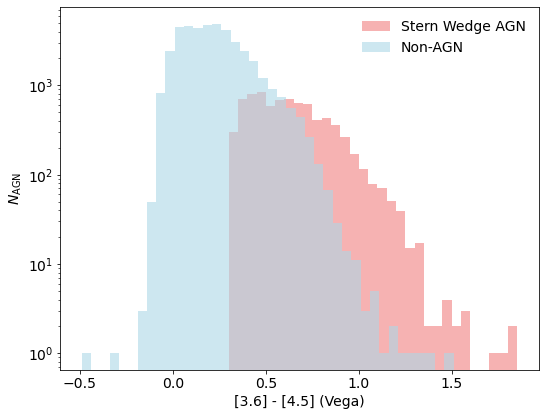

In [22]:
fig, ax = plt.subplots(figsize=(7.8, 6))
binwidth = 0.05
min_z = 0.
max_z = 1.8
bins_nonAGN = np.arange(non_agn['CH1_CH2_COLOR'].min(), non_agn['CH1_CH2_COLOR'].max() + binwidth, binwidth)
bins_AGN = np.arange(stern_agn['CH1_CH2_COLOR'].min(), stern_agn['CH1_CH2_COLOR'].max() + binwidth, binwidth)
ax.hist(stern_agn['CH1_CH2_COLOR'][(stern_agn['PHOT_Z'] > min_z) & (stern_agn['PHOT_Z'] < max_z)], bins=bins_AGN, color='lightcoral', alpha=0.6, label='Stern Wedge AGN')
ax.hist(non_agn['CH1_CH2_COLOR'][(non_agn['PHOT_Z'] > min_z) & (non_agn['PHOT_Z'] < max_z)], bins=bins_nonAGN, color='lightblue', alpha=0.6, label='Non-AGN')
# ax_hist.axhline(y=0.7, color='k', linewidth=2)
ax.legend(frameon=False)
ax.set(ylabel=r'$N_\mathrm{AGN}$', xlabel='[3.6] - [4.5] (Vega)', yscale='log')
fig.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_color_histogram_publication.pdf')